In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'breast-cancer-dataset' dataset.
Path to dataset files: /kaggle/input/breast-cancer-dataset


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

# Загрузка и раздение данных

In [4]:
data = load_breast_cancer()

X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names


df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

df.info()

print("Размер датасета:", X.shape)
print("\nЦелевая переменная:")
print(pd.Series(y).value_counts())
print(f"\nПризнаки: {list(feature_names)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nОбучающая выборка: {X_train.shape[0]} записей")
print(f"Тестовая выборка: {X_test.shape[0]} записей")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

# Создание моделей + стандартизация

In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.3 MB/s eta 0:00:00


In [6]:
import xgboost as xgb
from xgboost import XGBClassifier

# Определение параметров для GridSearch
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')


import lightgbm as lgb
from lightgbm import LGBMClassifier

lgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

lgb_model = LGBMClassifier(random_state=42, verbose=-1)

import catboost as cb
from catboost import CatBoostClassifier

cb_params = {
    'iterations': [100, 200, 300],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5]
}

cb_model = CatBoostClassifier(random_state=42, verbose=False)

**Подбор гиперпараметров + обучение**

In [7]:
def evaluate_models(models, params):

# """
# Функция для обучения и оценки моделей с подбором гиперпараметров
# """
  results = {}
  best_models = {}

  for name, model in models.items():
    print(f"  Обучение и настройка {name}...")
    start_time = time.time()
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(X_train_scaled, y_train)

    training_time = time.time() - start_time
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)


    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'test_accuracy': accuracy,
        'training_time': training_time,
        'model': grid_search.best_estimator_}

    best_models[name] = grid_search.best_estimator_

    print(f"{name} завершен:")
    print(f"Лучшие параметры: {grid_search.best_params_}")
    print(f"CV точность: {grid_search.best_score_:.4f}")
    print(f"Тест точность: {accuracy:.4f}")
    print(f"Время обучения: {training_time:.2f} сек\n")

  return results, best_models


models = {
    'XGBoost': xgb_model,
    'LightGBM': lgb_model,
    'CatBoost': cb_model
}

params = {
    'XGBoost': xgb_params,
    'LightGBM': lgb_params,
    'CatBoost': cb_params
}

results, best_models = evaluate_models(models, params)

  Обучение и настройка XGBoost...
XGBoost завершен:
Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
CV точность: 0.9736
Тест точность: 0.9474
Время обучения: 51.86 сек

  Обучение и настройка LightGBM...
LightGBM завершен:
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'num_leaves': 31}
CV точность: 0.9802
Тест точность: 0.9561
Время обучения: 42.34 сек

  Обучение и настройка CatBoost...
CatBoost завершен:
Лучшие параметры: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
CV точность: 0.9802
Тест точность: 0.9561
Время обучения: 774.67 сек



**Оценка на тестовой выборке**

In [11]:
test_results = {}
for name, model in best_models.items():
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  test_results[name] = accuracy

  print(f"\n{name}:")
  print(f"Точность: {accuracy:.4f}")
  print("Отчет классификации:")
  print(classification_report(y_test, y_pred, target_names=target_names))


XGBoost:
Точность: 0.3684
Отчет классификации:
              precision    recall  f1-score   support

   malignant       0.37      1.00      0.54        42
      benign       0.00      0.00      0.00        72

    accuracy                           0.37       114
   macro avg       0.18      0.50      0.27       114
weighted avg       0.14      0.37      0.20       114


LightGBM:
Точность: 0.3684
Отчет классификации:
              precision    recall  f1-score   support

   malignant       0.37      1.00      0.54        42
      benign       0.00      0.00      0.00        72

    accuracy                           0.37       114
   macro avg       0.18      0.50      0.27       114
weighted avg       0.14      0.37      0.20       114


CatBoost:
Точность: 0.3684
Отчет классификации:
              precision    recall  f1-score   support

   malignant       0.37      1.00      0.54        42
      benign       0.00      0.00      0.00        72

    accuracy                        

# Сравнение результатов

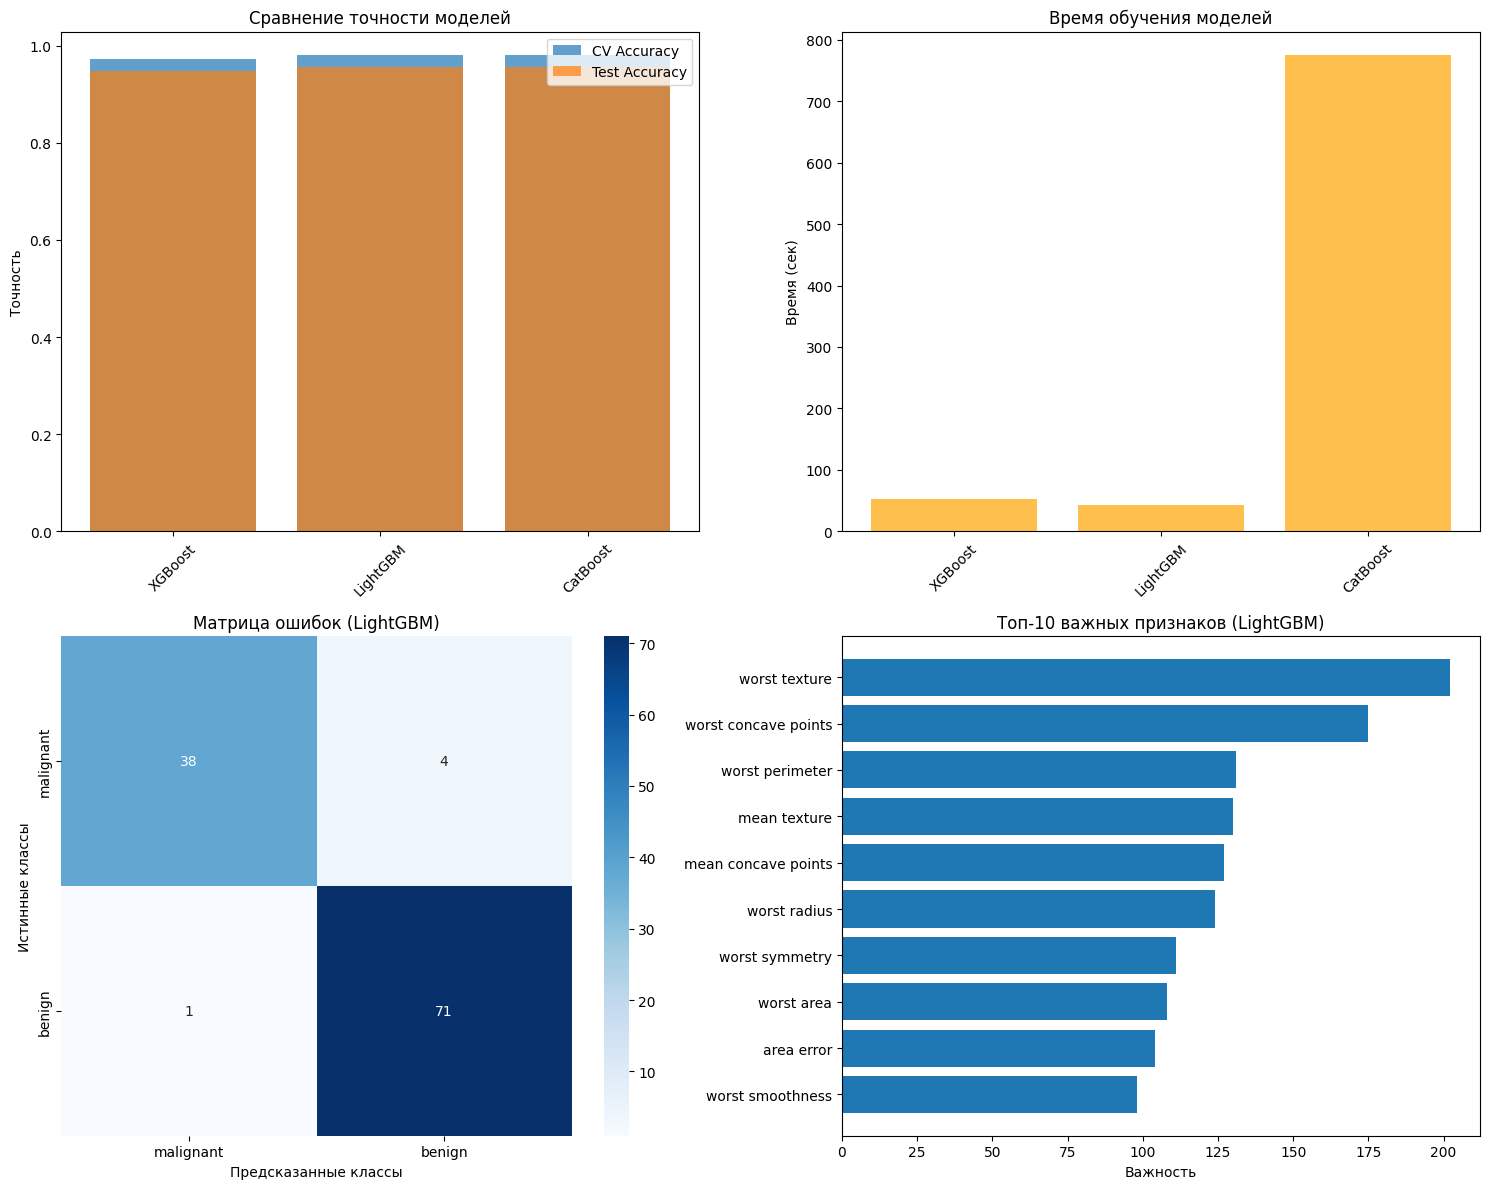

In [21]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_Accuracy': [results[name]['best_score'] for name in results.keys()],
    'Test_Accuracy': [results[name]['test_accuracy'] for name in results.keys()],
    'Training_Time': [results[name]['training_time'] for name in results.keys()]
})

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(comparison_df['Model'], comparison_df['CV_Accuracy'], alpha=0.7, label='CV Accuracy')
axes[0, 0].bar(comparison_df['Model'], comparison_df['Test_Accuracy'], alpha=0.7, label='Test Accuracy')
axes[0, 0].set_title('Сравнение точности моделей')
axes[0, 0].set_ylabel('Точность')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(comparison_df['Model'], comparison_df['Training_Time'], color='orange', alpha=0.7)
axes[0, 1].set_title('Время обучения моделей')
axes[0, 1].set_ylabel('Время (сек)')
axes[0, 1].tick_params(axis='x', rotation=45)

best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1, 0])
axes[1, 0].set_title(f'Матрица ошибок ({best_model_name})')
axes[1, 0].set_ylabel('Истинные классы')
axes[1, 0].set_xlabel('Предсказанные классы')

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True).tail(10)

    axes[1, 1].barh(feature_imp['feature'], feature_imp['importance'])
    axes[1, 1].set_title(f'Топ-10 важных признаков ({best_model_name})')
    axes[1, 1].set_xlabel('Важность')

plt.tight_layout()
plt.show()

# Интерпритация SHAP + визуализация результатов

---



In [9]:
!pip install --upgrade shap

Интерпретация лучшей модели с помощью SHAP...


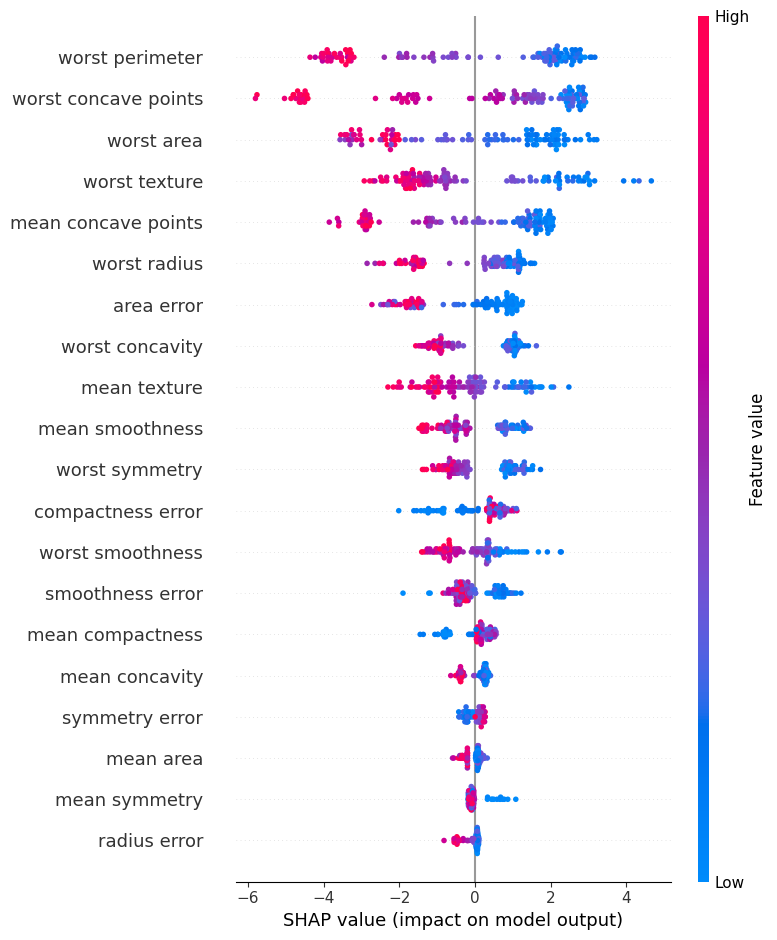

In [28]:
import shap

print("Интерпретация лучшей модели с помощью SHAP...")

X_shap = X_train_scaled
X_shap_test = X_test_scaled

if 'catboost' in str(type(best_model)).lower():
  explainer = shap.TreeExplainer(best_model)
  shap_values = explainer.shap_values(X_shap_test)
  shap.summary_plot(shap_values, X_shap_test, feature_names=feature_names)
elif "xgb" in str(type(best_model)).lower() or "lgbm" in str(type(best_model)).lower():
  explainer = shap.TreeExplainer(best_model)
  shap_values = explainer.shap_values(X_shap_test)

  if isinstance(shap_values, list) and len(shap_values) == 2:
    shap.summary_plot(shap_values[1], X_shap_test, feature_names=feature_names)
  else:
    shap.summary_plot(shap_values, X_shap_test, feature_names=feature_names)

else:
  explainer = shap.Explainer(best_model, X_shap)
  shap_values = explainer(X_shap_test, check_additivity=False)
  shap.summary_plot(shap_values, X_shap_test, feature_names=feature_names)


# Выводы + отчет

In [29]:
def generate_comprehensive_report(results, best_model_name, shap_values):
    # """
    # Генерация отчета по результатам экспериментов
    # """

    print("="*60)
    print("Отчет по сравнению бустинговых алгоритмов")
    print("="*60)


    best_accuracy = max(results, key=lambda x: results[x]['test_accuracy'])
    best_cv = max(results, key=lambda x: results[x]['best_score'])
    fastest = min(results, key=lambda x: results[x]['training_time'])

    print("\n Лучшие модели по критериям:")
    print(f"   • По тестовой точности: {best_accuracy} ({results[best_accuracy]['test_accuracy']:.4f})")
    print(f"   • По кросс-валидации: {best_cv} ({results[best_cv]['best_score']:.4f})")
    print(f"   • По скорости: {fastest} ({results[fastest]['training_time']:.2f} сек)")

    print("\n Сравнительный анализ по производительности:")
    for name in results.keys():
        speed_ratio = results[name]['training_time'] / results[fastest]['training_time']
        print(f"   • {name}: {results[name]['training_time']:.2f} сек ({speed_ratio:.1f}x)")

    print("\n Выводы:")
    print("   1. Точность моделей:")
    for name in results.keys():
        diff = results[name]['test_accuracy'] - results[name]['best_score']
        trend = "↑ переобучение" if diff > 0.02 else "↓ недообучение" if diff < -0.02 else "✓ стабильная"
        print(f"      - {name}: CV={results[name]['best_score']:.4f}, "
              f"Test={results[name]['test_accuracy']:.4f} ({trend})")

    print("\n   2. Рекомендации по выбору модели:")
    print("      • Использовать модель с наивысшей test accuracy")
    print("      • Учитывать баланс точности и скорости")
    print("      • Анализировать SHAP значения")

generate_comprehensive_report(results, best_model_name, shap_values)

Отчет по сравнению бустинговых алгоритмов

 Лучшие модели по критериям:
   • По тестовой точности: LightGBM (0.9561)
   • По кросс-валидации: LightGBM (0.9802)
   • По скорости: LightGBM (42.34 сек)

 Сравнительный анализ по производительности:
   • XGBoost: 51.86 сек (1.2x)
   • LightGBM: 42.34 сек (1.0x)
   • CatBoost: 774.67 сек (18.3x)

 Выводы:
   1. Точность моделей:
      - XGBoost: CV=0.9736, Test=0.9474 (↓ недообучение)
      - LightGBM: CV=0.9802, Test=0.9561 (↓ недообучение)
      - CatBoost: CV=0.9802, Test=0.9561 (↓ недообучение)

   2. Рекомендации по выбору модели:
      • Использовать модель с наивысшей test accuracy
      • Учитывать баланс точности и скорости
      • Анализировать SHAP значения
